### 03 WebサーチをするAIエージェント
#### 03_02 Workflow（Ollama）
gpt-oss:20b＋MCPサーバ構成のため、**Colab GPU は L4 を使用すること。**
- 必要なライブラリをインストール
- Google Colab に Ollama をセットアップ
- ChatOllama で LLM に接続
- MCPサーバ（ddg-search）によるweb検索の実装
- LangGraph による Workflow の実装
  1. ユーザの質問を入力。
  2. ユーザの質問に回答するためのタスク分割, 作成。
  3. MCPサーバ（ddg-search）によるweb検索。
  4. web検索を終えて回答作成に進むか判断。再調査なら 3 に戻る。
  5. ユーザへの回答の作成と提示。
- 動作確認

AIエージェントワークフローで参考にした設計
> [現場で活用するためのAIエージェント実践入門  chapter 4](https://github.com/masamasa59/genai-agent-advanced-book/tree/main/chapter4)

**必要なライブラリをインストール**
- 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
- 分割すると後勝ちで依存関係が壊れるリスクがある。
- NOTE: Colab では uv ではなく pip を使う。
> uv は依存解決の過程で numpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。

In [1]:
# Google Colab に必要なライブラリをインストールする。
# 1行にまとめることで pip が全パッケージの依存関係を一括解決する。
# NOTE: Colab では uv ではなく pip を使う。uv は依存解決の過程で
#       numpy 等をアップグレードし、プリインストール済みの scipy 等を壊すため。
# NOTE: langchain 関連は 1.x 系に明示的に指定する。
#       Colab プリインストールの 0.3.x が残ると langchain-mcp-adapters が動作しない。
# Pythonのリストとして定義することで、Pylanceの警告を防ぎ、可読性を高める。

# fmt: off
pkgs = [
    "ollama", "langchain-ollama",
    "langchain>=1.2.8", "langchain-core>=1.2.8", "langgraph>=1.0.7",
    "langchain-mcp-adapters>=0.2.1", "duckduckgo-mcp-server", "mcp",
]
# fmt: on

# リストを結合して pip に渡す
# magic command内で {変数} を使うと展開される機能を利用
%pip install -U -q {" ".join(pkgs)}

**Google Colab に Ollama をセットアップ**
- Ollama のインストール・起動・モデルのダウンロードを行う。
- 詳細は [01_connect_oss_llm.ipynb](01_connect_oss_llm.ipynb) を参照。

In [2]:
# Ollama のインストール・起動・モデルのダウンロード
# 詳細は 01_connect_oss_llm.ipynb を参照
import subprocess
import time
import ollama  # type: ignore

!apt-get install -y -qq zstd
!curl -fsSL https://ollama.com/install.sh | sh

process = subprocess.Popen(
    ["ollama", "serve"],
    stdout=subprocess.DEVNULL,
    stderr=subprocess.DEVNULL,
)
time.sleep(5)


# AI エージェントにはツールコール対応モデルが必要。
# NOTE: ollama pull のプログレスバーは Colab で文字化けするため、
#       Python API 経由でステータスのみ表示する。

model_name = "gpt-oss:20b"

for progress in ollama.pull(model_name, stream=True):
    status = progress.get("status", "")
    total = progress.get("total") or 0
    completed = progress.get("completed") or 0
    if total:
        line = f"{status}: {completed / total:.0%}"
    else:
        line = status
    print(f"\r{line:<60}", end="", flush=True)
print("\nDone!")
!ollama show {model_name}

Selecting previously unselected package zstd.
(Reading database ... 121852 files and directories currently installed.)
Preparing to unpack .../zstd_1.4.8+dfsg-3build1_amd64.deb ...
Unpacking zstd (1.4.8+dfsg-3build1) ...
Setting up zstd (1.4.8+dfsg-3build1) ...
Processing triggers for man-db (2.10.2-1) ...
>>> Installing ollama to /usr/local
>>> Downloading ollama-linux-amd64.tar.zst
######################################################################## 100.0%
>>> Creating ollama user...
>>> Adding ollama user to video group...
>>> Adding current user to ollama group...
>>> Creating ollama systemd service...
>>> The Ollama API is now available at 127.0.0.1:11434.
>>> Install complete. Run "ollama" from the command line.
success                                                     
Done!
  Model
    architecture        gptoss    
    parameters          20.9B     
    context length      131072    
    embedding length    2880      
    quantization        MXFP4     

  Capabilities
  

**ChatOllama で LLM に接続**
- 詳細は [01_connect_oss_llm.ipynb](01_connect_oss_llm.ipynb) を参照。

In [3]:
# ChatOllama で LLM に接続する。
from langchain_ollama import ChatOllama  # type: ignore

llm = ChatOllama(
    model="gpt-oss:20b",
    num_ctx=16384,
    num_predict=-1,
    temperature=0.8,
    top_k=40,
    top_p=0.9,
    repeat_penalty=1.1,
    reasoning=None,
)

**MCPサーバ（ddg-search）によるweb検索の実装**
- langchain-mcp-adapters の MultiServerMCPClient を使用。
- MCPサーバのツールが自動的に LangChain ツールに変換される（@tool の手動定義が不要）。
- ReAct エージェントが bind_tools() で認識し、自律的にツールを呼び出せる形式になる。

**MCPサーバ設定の補足**

github に記載されているMCP接続の設定は以下
> "mcpServers": {"ddg-search": {"command": "uvx", "args": ["duckduckgo-mcp-server"]}}

今回は、pip install済なので、command="duckduckgo-mcp-server" で直接起動。uvx経由ではないので、args=[] としてよい。

**Colab の stderr 問題の回避（Colab 特有。通常の Python 環境では不要）**

Colab の stderr は fileno() 未対応のため、MCP の stdio_client が失敗する。
stdio_client の関数シグネチャ `errlog=sys.stderr` は**インポート時に評価が確定**するため、
後から sys.stderr を差し替えても効果がない（Python のデフォルト引数の仕様）。
そこで、langchain_mcp_adapters.sessions 内の stdio_client 参照自体を、
errlog のデフォルトを /dev/null に変更したラッパー関数に差し替えて回避する。

**httpx 0.28 互換性の回避（Colab 特有。通常の Python 環境では不要の可能性あり）**

duckduckgo-mcp-server は httpx.TimeoutError を参照するが、依存先の httpx 0.28 で
この属性が削除された（duckduckgo-mcp-server 側のバグ）。
MCP サーバはサブプロセスで動作するため、ノートブック側のパッチが効かない。
そこで、httpx をパッチしてからサーバを起動する Python ラッパー経由で起動する。

In [4]:
# MCPサーバ（duckduckgo-mcp-server）に接続し、LangChainツールを自動取得
# langchain-mcp-adapters が MCP ツールを LangChain 互換に自動変換するため、
# @tool による手動ラップが不要
import os
import sys
import contextlib
from langchain_mcp_adapters import sessions as _sessions  # type: ignore
from langchain_mcp_adapters.client import MultiServerMCPClient  # type: ignore

# --- Colab stderr 問題の回避パッチ（Colab 特有。通常環境では不要） ---
# stdio_client(server, errlog=sys.stderr) のデフォルト値はインポート時に確定する。
# Colab の stderr は fileno() 未対応のため、デフォルトのまま呼ぶと失敗する。
# → errlog のデフォルトを /dev/null に差し替えたラッパーで上書きして回避する。
# NOTE: _devnull はセッション中ずっと開いたままにする（閉じると書き込み先がなくなる）
_devnull = open(os.devnull, "w")
_original_stdio_client = _sessions.stdio_client


@contextlib.asynccontextmanager
async def _patched_stdio_client(server, errlog=_devnull):
    async with _original_stdio_client(server, errlog=errlog) as result:
        yield result


_sessions.stdio_client = _patched_stdio_client


# httpx 0.28 で削除された TimeoutError を復元してからサーバを起動するラッパー
# duckduckgo-mcp-server はサブプロセスで動くため、ノートブック側のパッチが効かない
_MCP_LAUNCHER = (
    "import httpx; "
    "httpx.TimeoutError = getattr(httpx, 'TimeoutError', "
    "type('TimeoutError', (Exception,), {})); "
    "exec(open(__import__('shutil').which('duckduckgo-mcp-server')).read())"
)

mcp_client = MultiServerMCPClient(
    {
        "ddg-search": {
            "transport": "stdio",
            "command": sys.executable,  # python 本体を起動
            "args": ["-c", _MCP_LAUNCHER],  # パッチ付きラッパー
        }
    }
)

# MCP ツールを LangChain ツールとして自動取得
tools = await mcp_client.get_tools()

print("=== AI エージェント用ツール ===")
for t in tools:
    print(f"  - {t.name}: {t.description}")

=== AI エージェント用ツール ===
  - search: 
    Search DuckDuckGo and return formatted results.

    Args:
        query: The search query string
        max_results: Maximum number of results to return (default: 10)
        ctx: MCP context for logging
    
  - fetch_content: 
    Fetch and parse content from a webpage URL.

    Args:
        url: The webpage URL to fetch content from
        ctx: MCP context for logging
    


**LangGraph による Workflow の実装**

ReAct エージェント（03_01）は LLM が自律的にツールを呼び出すが、Workflow ではグラフ構造で処理フローを明示的に制御する。

**Workflow の流れ**
1. **task_planning**: ユーザの質問を受け取り、回答に必要な **サブタスク**（目的＋検索クエリ）を構造化して作成する。
2. **web_search**: 各サブタスクの検索クエリを実行し、目的と紐付けた検索結果を蓄積する。
3. **judge**: サブタスクの目的ごとに、検索結果が十分かを LLM が判断する。不足なら追加サブタスクを生成して web_search に戻る。
4. **generate_answer**: 目的ごとに整理された検索結果をもとに、ユーザの質問に対する最終回答を生成する。

**サブタスク構造**
```json
{"purpose": "調査の目的", "queries": ["検索クエリ1", "検索クエリ2"]}
```
- `purpose`: そのサブタスクで明らかにしたいこと（judge での判定基準になる）。
- `queries`: 目的を達成するための具体的な検索クエリ。

**ReAct との違い**
- ReAct: LLM が思考→行動→観察のループを自律的に回す。ツール選択も LLM 任せ。
- Workflow: 開発者がグラフで処理順序を定義し、各ノードの役割を明確に分離する。制御フローが予測可能。

**Workflow の状態定義とツールの設定**

MCP サーバ（ddg-search）は `search`（検索）と `fetch_content`（URL 本文取得）の2つのツールを提供するが、本 Workflow では `search` のみを使用する。

`fetch_content` を追加しない理由:
- `num_ctx=16384` の制約下では、Web ページ本文（数千〜数万トークン）を格納するとコンテキストがオーバーフローする。
- 回避には fetch 後の LLM 要約が必要だが、スクレイピング, テキスト情報のクリーニング, RAG（検索拡張生成）などの実装が必要となり、notebook実装としては複雑すぎる。
- DuckDuckGo のスニペットで回答品質が不足する場合に、限定的な導入（上位1件のみ fetch → 要約）を検討する。

**LLM との入出力形式**

各ノードは `messages` 引数で `[SystemMessage(...), HumanMessage(...)]` のリストを渡す統一形式を使用する。
システムプロンプトは次のセルで定数として一括定義し、ノード関数はロジックに専念する。

In [5]:
# Workflow の状態定義と共通インポート
import json  # noqa: F811
from typing import TypedDict
from langchain_core.messages import HumanMessage, SystemMessage  # type: ignore
from langgraph.graph import StateGraph, START, END  # type: ignore
from IPython.display import Image, display

# --- グローバル設定 ---
MAX_LOOP_COUNT = 2  # judge → web_search 再調査ループの上限回数（無限ループ防止）
MAX_SEARCH_RESULTS = 5  # search ツールが返す検索結果の最大件数

# --- 検索ツールの参照を取得 ---
# next() の第2引数 None により、見つからない場合は StopIteration ではなく None を返す。
# 直後の assert で None でないことを保証するため、以降 search_tool は BaseTool 型として扱える。
search_tool = next((t for t in tools if t.name == "search"), None)
assert search_tool is not None, "search ツールが見つかりませんでした。"


# --- Workflow の状態 ---
class WorkflowState(TypedDict):
    question: str  # ユーザの質問
    subtasks: list[dict]  # サブタスク [{"purpose": str, "queries": [str]}]
    search_results: list[str]  # 目的と紐付けた検索結果
    answer: str  # 最終回答
    loop_count: int  # 再調査ループ回数（無限ループ防止）

**共通ユーティリティ: `extract_json_text`**

LLM の出力から JSON 文字列を抽出するユーティリティ。

`raw.strip()` で、LLM が出力したテキストから、文字列の両端にある空白文字（改行、スペース、タブなど）をすべて取り除く。「文字の間」にある空白には影響しない。

さらに、LLM の出力で起こりがちな、以下の3ケースに対応する。
1. **コードブロック**: ` ```json ... ``` ` — 正規表現でコードブロック内の中身を抽出する。
2. **前後にテキスト付き**: `"以下がサブタスクです: [{...}]"` — 最初の `[` or `{` から、対応する最後の `]` or `}` までを切り出す。
3. **JSON のみ**: `[{...}]` or `{...}` — そのままパース可能。

抽出後は `json.loads()` で Python のリスト型/辞書型に変換する。

In [6]:
# 共通ユーティリティ: LLM 出力から JSON 文字列を抽出する
import json  # noqa: F811
import re


def extract_json_text(raw: str) -> str:
    """LLM の出力から JSON 文字列を抽出する。

    以下のケースに対応:
    1. コードブロック: ```json ... ``` or ``` ... ```
    2. 前後にテキスト付き: "以下がサブタスクです: [{...}]"
    3. JSON のみ: [{...}] or {...}
    """
    text = raw.strip()

    # ケース 1: コードブロックの除去
    # 複数のコードブロックがある場合も考慮し、単純な split ではなく正規表現で中身を抽出
    code_block_match = re.search(r"```(?:json)?\s*(.*?)```", text, re.DOTALL)
    if code_block_match:
        text = code_block_match.group(1).strip()

    # コードブロック内が正常な JSON ならそのまま返す
    try:
        json.loads(text)
        return text
    except json.JSONDecodeError:
        pass  # パースできなければ、テキスト全体からの抽出（ケース 2, 3）へ進む

    # ケース 2, 3: テキスト混じりの場合
    # 「最初の { か [」を探し、対応する「最後の } か ]」を探して切り出す
    match_start = re.search(r"[\{\[]", text)
    if not match_start:
        return text  # JSON の開始記号がない

    first_brace_index = match_start.start()
    start_char = text[first_brace_index]
    end_char = "]" if start_char == "[" else "}"

    last_brace_index = text.rfind(end_char)
    if last_brace_index > first_brace_index:
        return text[first_brace_index : last_brace_index + 1]

    return text

**各ノードのシステムプロンプト定義**

各ノード（task_planning / judge / generate_answer）が LLM に渡すシステムプロンプトを一箇所に集約する。
- プロンプトの確認・調整が容易になる。
- ノード関数のロジックとプロンプトの関心を分離する。

**参考：JSON データ形式**
- `key` : `value` の組から構成されるデータ
- `{ }` で、`"purpose"` と `"queries"` で 1セットのデータ（辞書）として定義
- `[ ]` で、辞書：`{ }` のリストとして定義
- ... は、`{ }` の部分の繰り返しであることを意味する
- JSON の仕様では、true/false。Python の仕様では、True/False。`SYSTEM_PROMPT_JUDGE` の `"sufficient"` の判定は、JSON の仕様で出力するので、true/falseで記述。

In [7]:
# 各ノードのシステムプロンプト定義
# ノード関数のロジックとプロンプトの関心を分離するため、一箇所に集約する。
SYSTEM_PROMPT_TASK_PLANNING = """
あなたはリサーチプランナーです。
ユーザの質問に回答するために必要な調査サブタスクを作成してください。

出力は以下の JSON 配列のみとし、他のテキストは一切含めないでください。
サブタスクは最大3個までとしてください。

出力形式:
[
  {"purpose": "このサブタスクで明らかにしたいこと",
   "queries": ["検索クエリ1", "検索クエリ2"]},
  ...
]

purpose は判定ステップで「この目的に十分な情報が得られたか」を評価する基準になります。
具体的かつ明確に書いてください。
"""

SYSTEM_PROMPT_JUDGE = """
あなたはリサーチの品質を判定する審査員です。
ユーザの質問と検索結果を見て、回答に十分な情報があるか判断してください。
検索結果には【目的: ...】タグが付いています。
各目的について十分な情報が得られているかを確認してください。

十分な場合:
{"sufficient": true, "reason": "判断理由を日本語で1文で"}

不足の場合（不足している目的について追加サブタスクを生成）:
{"sufficient": false, "reason": "何が不足しているかを日本語で1文で",
 "additional_subtasks": [
    {"purpose": "追加で明らかにしたいこと",
     "queries": ["追加クエリ1"]}
  ]
}

JSON のみ出力し、他のテキストは含めないでください。
"""

SYSTEM_PROMPT_GENERATE_ANSWER = """
あなたはリサーチ結果をもとに回答するAIアシスタントです。
検索結果を参考に、ユーザの質問に日本語で丁寧に回答してください。
回答の最後に、以下の形式で結論をまとめてください。

# 結論
- ユーザの質問: （質問内容）
- 回答: （簡潔な回答）
"""

**ノード 1: task_planning（タスク分割）**
- ユーザの質問を分析し、回答に必要な **サブタスク**（目的＋検索クエリ）を構造化して作成する。
- 各サブタスクは `purpose`（何を明らかにしたいか）と `queries`（検索クエリ群）で構成される。
- LLM に JSON 配列のみを出力させ、パースして `subtasks` に格納する。

**参考：JSON 配列のパース**
- `extract_json_text` で実施。**共通ユーティリティ**を参照。

In [8]:
# ノード 1: task_planning（タスク分割）
async def task_planning(state: WorkflowState) -> dict:
    """ユーザの質問を分析し、サブタスク（目的＋検索クエリ）を作成する。"""
    question = state["question"]

    response = await llm.ainvoke(
        [
            SystemMessage(content=SYSTEM_PROMPT_TASK_PLANNING),
            HumanMessage(content=question),
        ]
    )

    # LLM の出力から JSON 配列を抽出
    text = extract_json_text(response.content)

    try:
        subtasks = json.loads(text)
    except json.JSONDecodeError:
        # パース失敗時は質問そのものを検索クエリにして続行する
        print(f"[task_planning] JSON パース失敗 → フォールバック: {text[:100]}")
        subtasks = [{"purpose": "基本調査", "queries": [question]}]

    print(f"[task_planning] サブタスク数: {len(subtasks)}")
    for i, st in enumerate(subtasks):
        print(f"  {i + 1}. 目的: {st['purpose']}")
        print(f"     クエリ: {st['queries']}")
    return {"subtasks": subtasks, "search_results": [], "loop_count": 0}

In [9]:
# task_planning の単体確認
# ensure_ascii=False の指定をしないと日本語が文字化けするので注意
_test_state = {"question": "2025年の日本の総人口は何人ですか？"}
_result = await task_planning(_test_state)

print(f"\nsubtasks: {json.dumps(_result['subtasks'], ensure_ascii=False, indent=2)}")
assert isinstance(_result["subtasks"], list), "subtasks がリストではありません"
assert len(_result["subtasks"]) > 0, "サブタスクが空です"
for st in _result["subtasks"]:
    assert "purpose" in st, f"purpose キーがありません: {st}"
    assert "queries" in st, f"queries キーがありません: {st}"
    assert isinstance(st["queries"], list), f"queries がリストではありません: {st}"
print("OK")

[task_planning] サブタスク数: 2
  1. 目的: 日本政府が公表した2025年の総人口推計値を確認する
     クエリ: ['2025 年 日本 総人口 推計 日本統計局', '内閣府 2025 年人口見通し 日本']
  2. 目的: 民間調査機関や国際機関の報告書で2025年の日本人口予測を比較検証する
     クエリ: ['2025 年 日本 人口予測 OECD', '2025 日本人口 推計 民間調査']

subtasks: [
  {
    "purpose": "日本政府が公表した2025年の総人口推計値を確認する",
    "queries": [
      "2025 年 日本 総人口 推計 日本統計局",
      "内閣府 2025 年人口見通し 日本"
    ]
  },
  {
    "purpose": "民間調査機関や国際機関の報告書で2025年の日本人口予測を比較検証する",
    "queries": [
      "2025 年 日本 人口予測 OECD",
      "2025 日本人口 推計 民間調査"
    ]
  }
]
OK


**ノード 2: web_search（Web 検索）**

`subtasks` 内の各サブタスクについて、`queries` を順番に MCP の `search` ツールで実行する。
- `list(state.get("search_results") or [])` で、「初回実行時は空リスト、2回目（ループ時）は前回の結果を引き継ぐ」として動作させる。list(...) で囲うことにより、元のデータをコピーして壊さないようにしている。
- 検索結果はサブタスクの `purpose`（目的）と紐付けて `search_results` に蓄積する。
> `results.append` で、目的: {purpose}, クエリ: {query}, {result} のように構造化したデータとして保存。
- 実行済みのサブタスクは `subtasks` からクリアされる。
> `"subtasks": []` でサブタスクを空にしている。
- 検索結果が空（DuckDuckGo のbot検出等）の場合は蓄積せずスキップし、judge が不要な再調査を行うのを防ぐ。

**逐次実行 + 待機を採用する理由**
- DuckDuckGo は同一IPからの短時間の大量リクエストをbot検出する。
- `asyncio.gather` 等で並列化するとバースト的なリクエストになり、全クエリがブロックされるリスクが高い。
- 逐次実行かつクエリ間に `_SEARCH_INTERVAL_SEC`（1秒）の待機を入れることで、bot検出を回避する。

In [10]:
# ノード 2: web_search（Web 検索）
import asyncio

# 検索結果が空かどうかを判定するキーワード
_NO_RESULT_KEYWORDS = ["No results were found", "no matching results"]

# 検索クエリ間の待機時間（秒）。DuckDuckGo のbot検出を回避するため。
_SEARCH_INTERVAL_SEC = 1.0


async def web_search(state: WorkflowState) -> dict:
    """各サブタスクの検索クエリを逐次実行し、目的と紐付けて結果を蓄積する。"""
    subtasks = state["subtasks"]
    results = list(state.get("search_results") or [])
    is_first_query = True

    for st in subtasks:
        purpose = st["purpose"]
        print(f"[web_search] 目的: {purpose}")
        for query in st["queries"]:
            # 2回目以降のクエリは待機してからbot検出を回避
            if not is_first_query:
                await asyncio.sleep(_SEARCH_INTERVAL_SEC)
            is_first_query = False

            print(f"  検索中: {query}")
            try:
                result = await search_tool.ainvoke(
                    {"query": query, "max_results": MAX_SEARCH_RESULTS}
                )
            except Exception as e:
                print(f"  [ERROR] クエリ失敗: {query} → {e}")
                continue
            # 検索結果が空（bot検出等）の場合はスキップ
            result_str = str(result)
            if any(kw in result_str for kw in _NO_RESULT_KEYWORDS):
                print(f"  [SKIP] 検索結果なし: {query}")
                continue
            results.append(f"【目的: {purpose}】\n【クエリ: {query}】\n{result}")

    return {"search_results": results, "subtasks": []}

In [11]:
# web_search の単体確認
_test_state = {
    "question": "2025年の日本の総人口は何人ですか？",
    "subtasks": [
        {
            "purpose": "2025年の日本の総人口の最新の公式発表値を確認する",
            "queries": ["2025年 日本 総人口", "総務省 2025年 人口推計"],
        }
    ],
    "search_results": [],
}
_result = await web_search(_test_state)

print(f"\n検索結果数: {len(_result['search_results'])}")
# DuckDuckGo のbot検出で空結果がスキップされる場合があるため、
# 結果数は 0〜2 の範囲で正常とする
assert len(_result["search_results"]) <= 2, (
    f"クエリ2本に対して結果が {len(_result['search_results'])} 件は多すぎます"
)
if _result["search_results"]:
    print(f"結果1（先頭200文字）: {_result['search_results'][0][:200]}")
    assert "【目的:" in _result["search_results"][0], "目的タグが付いていません"
else:
    print("[INFO] 全クエリが空結果のためスキップされました（bot検出の可能性）")
print("OK")

[web_search] 目的: 2025年の日本の総人口の最新の公式発表値を確認する
  検索中: 2025年 日本 総人口
  検索中: 総務省 2025年 人口推計

検索結果数: 2
結果1（先頭200文字）: 【目的: 2025年の日本の総人口の最新の公式発表値を確認する】
【クエリ: 2025年 日本 総人口】
[{'type': 'text', 'text': 'Found 5 search results:\n\n1. 人口推計（2025年（令和7年）8月確定値、2026年（令和8年）1月概算値） （2026年1月20日公表）\n   URL: https://www.stat.go.jp/dat
OK


**ノード 3: judge（判定）+ ルーター**
- サブタスクの**目的ごと**に、検索結果が十分かを LLM が判断する。
- 全ての目的が達成されていれば `generate_answer` へ進む。
- 不足する目的があれば、追加サブタスク（目的＋クエリ）を生成して `web_search` に戻る。
- 無限ループ防止のため、再調査は最大2回まで。
- `should_continue_search` ルーターが judge の出力（`subtasks` の有無）を見て次のノードを決定する。

**参考：JSON 配列のパース**
- `extract_json_text` で実施。**共通ユーティリティ**を参照。

In [12]:
# ノード 3: judge（判定）
async def judge(state: WorkflowState) -> dict:
    """サブタスクの目的ごとに検索結果が十分かを判断し、不足なら追加サブタスクを生成する。"""
    question = state["question"]
    results = state["search_results"]
    loop_count = state.get("loop_count", 0)  # 値が空の場合に 0 をセットする

    # 無限ループ防止: MAX_LOOP_COUNT 回まで再調査
    if loop_count >= MAX_LOOP_COUNT:
        print("[judge] ループ上限に到達 → 回答作成へ")
        return {"subtasks": [], "loop_count": loop_count}

    # LLM テキストを渡すために、検索結果を 1つの文章に結合（区切り：\n\n）
    results_text = "\n\n".join(results)

    response = await llm.ainvoke(
        [
            SystemMessage(content=SYSTEM_PROMPT_JUDGE),
            HumanMessage(content=f"質問: {question}\n\n検索結果:\n{results_text}"),
        ]
    )

    text = extract_json_text(response.content)

    try:
        judgment = json.loads(text)
    except json.JSONDecodeError:
        # パース失敗時は十分と見なして先に進む
        print(f"[judge] JSON パース失敗 → 回答作成へ: {text[:100]}")
        return {"subtasks": [], "loop_count": loop_count + 1}

    reason = judgment.get("reason", "")  # 値が空の場合に ""（空）をセットする

    if judgment.get("sufficient", True):
        print(f"[judge] 情報十分 → 回答作成へ（理由: {reason}）")
        return {"subtasks": [], "loop_count": loop_count + 1}
    else:
        additional = judgment.get("additional_subtasks", [])
        print(f"[judge] 情報不足（理由: {reason}）→ 追加サブタスク:")
        for i, st in enumerate(additional):
            print(f"  {i + 1}. 目的: {st.get('purpose', '?')}")
            print(f"     クエリ: {st.get('queries', [])}")
        return {"subtasks": additional, "loop_count": loop_count + 1}


# ルーター: judge の結果で分岐
def should_continue_search(state: WorkflowState) -> str:
    """追加サブタスクがあれば web_search に戻り、なければ回答生成へ。"""
    if state.get("subtasks"):
        return "web_search"
    return "generate_answer"

In [13]:
# judge + ルーターの単体確認
_test_state = {
    "question": "2025年の日本の総人口は何人ですか？",
    "subtasks": [],
    "search_results": [
        "【目的: 2025年の日本の総人口の最新の公式発表値を確認する】\n"
        "【クエリ: 2025年 日本 総人口】\n"
        "総務省発表: 2025年1月1日時点の住民基本台帳に基づく総人口は1億2433万690人"
    ],
    "loop_count": 0,
}
_result = await judge(_test_state)

print(f"subtasks: {_result['subtasks']}")
print(f"loop_count: {_result['loop_count']}")

# ルーターの確認
_next = should_continue_search({**_test_state, **_result})
print(f"ルーター判定: {_next}")
assert _next in ("web_search", "generate_answer"), f"不正なルーター出力: {_next}"
print("OK")

[judge] 情報十分 → 回答作成へ（理由: 検索結果に公式発表値が含まれているため質問に十分に回答できる）
subtasks: []
loop_count: 1
ルーター判定: generate_answer
OK


**ノード 4: generate_answer（回答生成）**
- 目的ごとに整理された検索結果をもとに、ユーザの質問に対する最終回答を生成する。
- 検索結果に含まれる【目的: ...】タグにより、LLM が情報の文脈を把握しやすくなる。
- 回答の最後に「結論」セクションを付ける。

In [14]:
# ノード 4: generate_answer（回答生成）
async def generate_answer(state: WorkflowState) -> dict:
    """蓄積した検索結果をもとに最終回答を生成する。"""
    question = state["question"]
    results_text = "\n\n".join(state["search_results"])

    response = await llm.ainvoke(
        [
            SystemMessage(content=SYSTEM_PROMPT_GENERATE_ANSWER),
            HumanMessage(content=f"質問: {question}\n\n検索結果:\n{results_text}"),
        ]
    )

    answer = response.content or ""

    # content が空の場合、レスポンスの他の属性を確認する
    if not answer:
        print("[generate_answer] WARNING: response.content が空です")
        print(f"  response type: {type(response)}")
        print(f"  response keys: {list(response.__dict__.keys())}")
        print(f"  response repr: {repr(response)[:500]}")
        # additional_kwargs に内容がある場合のフォールバック
        additional = getattr(response, "additional_kwargs", {})
        if additional:
            print(f"  additional_kwargs: {repr(additional)[:300]}")

    print("[generate_answer] 回答生成完了")
    return {"answer": answer}

In [15]:
# generate_answer の単体確認
from IPython.display import Markdown

_test_state = {
    "question": "2025年の日本の総人口は何人ですか？",
    "search_results": [
        "【目的: 2025年の日本の総人口の最新の公式発表値を確認する】\n"
        "【クエリ: 2025年 日本 総人口】\n"
        "総務省発表: 2025年1月1日時点の住民基本台帳に基づく総人口は1億2433万690人。"
        "前年より55万4485人(0.44%)減少。日本人は1億2065万3227人で0.75%減少。"
    ],
}
_result = await generate_answer(_test_state)

assert "answer" in _result, "answer キーが存在しません"
assert len(_result["answer"]) > 0, "回答が空です"
display(Markdown(_result["answer"]))

[generate_answer] 回答生成完了


2025年1月1日時点の総務省の住民基本台帳に基づく公式発表によると、全国総人口は **1億2,433万6,900人** です。前年からは約55万人減少しています。

# 結論
- ユーザの質問: 2025年の日本の総人口は何人ですか？
- 回答: 1億2,433万6,900人です。

**Workflow グラフの構築**
- 上記4つのノードを StateGraph に登録し、エッジで接続する。
- `judge` ノードの後に条件分岐（`should_continue_search`）を設定する。

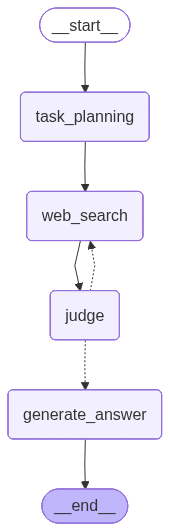

In [16]:
# Workflow グラフの構築とコンパイル
workflow = StateGraph(WorkflowState)

# ノードの登録
workflow.add_node("task_planning", task_planning)
workflow.add_node("web_search", web_search)
workflow.add_node("judge", judge)
workflow.add_node("generate_answer", generate_answer)

# エッジの定義
workflow.add_edge(START, "task_planning")
workflow.add_edge("task_planning", "web_search")
workflow.add_edge("web_search", "judge")

# 条件分岐: judge → web_search（再調査） or generate_answer（回答生成）
workflow.add_conditional_edges(
    "judge",
    should_continue_search,
    {
        "web_search": "web_search",
        "generate_answer": "generate_answer",
    },
)
workflow.add_edge("generate_answer", END)

# コンパイル
app = workflow.compile()

# グラフの可視化
display(Image(app.get_graph().draw_mermaid_png()))

**動作確認**
- Workflow エージェントに質問を投げ、タスク分割 → Web 検索 → 判定 → 回答生成の流れを確認する。

In [17]:
# Workflow エージェントの動作確認
# MCPツールは非同期専用のため ainvoke を使用する
import io
import sys
from IPython.display import Markdown, HTML, display

# 中間ログをキャプチャしつつ、リアルタイムでもセルに出力する
log_buffer = io.StringIO()


class TeeStream:
    """stdout への出力を画面表示しつつバッファにも記録する。"""

    def __init__(self, original, buffer):
        self.original = original
        self.buffer = buffer

    def write(self, text):
        self.original.write(text)
        self.buffer.write(text)

    def flush(self):
        self.original.flush()


_original_stdout = sys.stdout
sys.stdout = TeeStream(_original_stdout, log_buffer)
try:
    result = await app.ainvoke({"question": "2025年の日本の総人口は何人ですか？"})
finally:
    sys.stdout = _original_stdout

# 中間ログを HTML で全文表示（Colab のセル出力トランケートを回避）
log_text = log_buffer.getvalue()
print("\n--- 以下は HTML による全文ログ（トランケート回避） ---")
display(HTML(f"<pre style='white-space:pre-wrap'>{log_text}</pre>"))

# 最終回答の表示
print("=== Workflow エージェントの実行結果 ===\n")
answer = result.get("answer", "")
if answer:
    display(Markdown(answer))
else:
    print("[WARNING] 回答が空です。result keys:", list(result.keys()))
    print("search_results 件数:", len(result.get("search_results", [])))
    print("loop_count:", result.get("loop_count"))

[task_planning] サブタスク数: 3
  1. 目的: Find the most recent official estimate of Japan's total population for the year 2025, preferably from the Japanese government or an authoritative international organization.
     クエリ: ['Japan population estimate 2025', '国勢調査 2025 人口推計', 'Japan 2025 population forecast official']
  2. 目的: Verify the 2025 population figure by comparing it with independent sources such as the United Nations, World Bank, or OECD to ensure consistency and accuracy.
     クエリ: ['United Nations population estimates Japan 2025', 'World Bank Japan population 2025', 'OECD Japan population 2025']
  3. 目的: Cross‑check the 2025 estimate with recent news articles or academic papers that discuss Japan's demographic trends to confirm that the figure is up to date and reflects any recent revisions.
     クエリ: ['Japan 2025 population trend article', '2025 Japanese population projection news', 'Japan demographic forecast 2025 academic paper']
[web_search] 目的: Find the most recent official

=== Workflow エージェントの実行結果 ===



2025年の日本の総人口は、**約1億2326万8千人**（123,268,000人）です。  
これは、総務省（国勢調査）による2025年8月1日現在の確定値で、政府統計の公式推計値として最も信頼性が高いデータです。  

# 結論  
- ユーザの質問: 2025年の日本の総人口は何人ですか？  
- 回答: 2025年8月1日現在の総務省の確定値で、約1億2326万8千人です。